# Wide-field imaging demonstration

### This script makes a fake data set, fills it with a number of point components, and then images it. 

In [1]:
%matplotlib inline

import os
import sys

sys.path.append(os.path.join('..', '..'))

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (8.0, 8.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from arl.visibility.operations import create_visibility
from arl.skymodel.operations import create_skycomponent
from arl.image.operations import show_image, export_image_to_fits
from arl.image.iterators import raster_iter
from arl.visibility.iterators import vis_timeslice_iter
from arl.util.testing_support import create_named_configuration
from arl.fourier_transforms.ftprocessor import invert_2d, create_image_from_visibility, \
    weight_visibility, predict_skycomponent_visibility, create_w_term_image, invert_by_image_partitions, \
    invert_timeslice

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

doplot = True

### Set up imaging parameters

In [2]:
params = {'npixel': 256,
          'npol': 1,
          'cellsize': 0.001,
          'spectral_mode': 'channel',
          'channelwidth': 5e7,
          'reffrequency': 1e8,
          'kernel':'calculated'}

### Construct the SKA1-LOW core configuration

In [3]:
lowcore = create_named_configuration('LOWBD2-CORE')

### We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [4]:
times = numpy.arange(-numpy.pi / 4.0, +numpy.pi * 1.01 / 4.0, numpy.pi / 8)
frequency = numpy.array([1e8])

reffrequency = numpy.max(frequency)
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-35.0 * u.deg, frame='icrs', equinox=2000.0)
vt = create_visibility(lowcore, times, frequency, weight=1.0, phasecentre=phasecentre, params=params)

create_visibility: Created 68475 rows


### Plot the synthesized UV coverage.

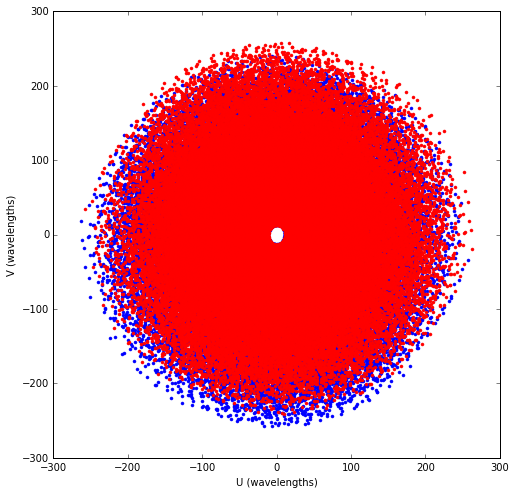

In [5]:
if doplot:
    plt.clf()
    for f in frequency:
        x = f / const.c
        plt.plot(x * vt.data['uvw'][:, 0], x * vt.data['uvw'][:, 1], '.', color='b')
        plt.plot(-x * vt.data['uvw'][:, 0], -x * vt.data['uvw'][:, 1], '.', color='r')
        plt.xlabel('U (wavelengths)')
        plt.ylabel('V (wavelengths)')

### Look at the phase term due to w. Evaluate this for the median absolute w. 

ftprocessor.create_w_term_image: Creating w term image for median w 70.431215
fourier_transforms.create_wcs_from_visibility: Parsing parameters to get definition of WCS
fourier_transforms.create_wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15.0, -35.0)>, frequency 100000000.0 Hz, and bandwidth 50000000.0 Hz
create_wcs_from_visibility: uvmax = 262.634709 lambda
create_wcs_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_wcs_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
ftprocessor.create_w_term_image: Fresnel number for median w and this field of view and sampling = 1.15


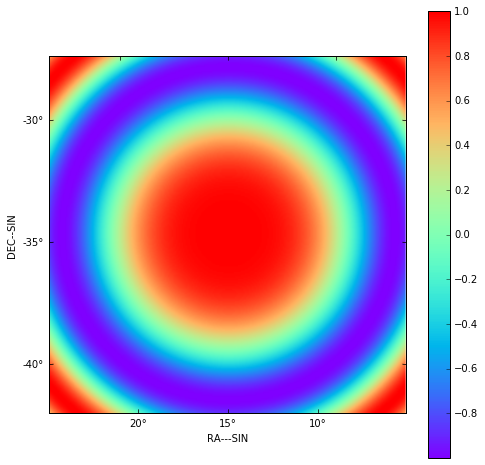

In [6]:
if doplot:
    wterm = create_w_term_image(vt, params=params)
    show_image(wterm)
    plt.show()

### Create a grid of components and predict each in turn, using the full phase term including w.

In [7]:
params = {'npixel': 256,
          'npol': 1,
          'cellsize': 0.001,
          'spectral_mode': 'channel',
          'channelwidth': 5e7,
          'reffrequency': 1e8,
          'kernel':'calculated',
          'image_partitions':4}

flux = numpy.array([[100.0]])
vt.data['vis'] *= 0.0

model = create_image_from_visibility(vt, params=params)
spacing_pixels = params['npixel'] // params['image_partitions']
log.info('Spacing in pixels = %s' % spacing_pixels)
spacing = 180.0 * params['cellsize'] * spacing_pixels / numpy.pi
centers = -1.5, -0.5, +0.5, +1.5
for iy in centers:
    for ix in centers:
        pra, pdec = int(round(params['npixel'] // 2 + ix * spacing_pixels - 1)),\
                    int(round*params['npixel'] // 2 + iy * spacing_pixels - 1))
        sc = pixel_to_skycoord(pra, pdec, model.wcs)
        log.info("Component at (%f, %f) %s" % (pra, pdec, str(sc)))
        comp = create_skycomponent(flux=flux, frequency=frequency, direction=sc)
        predict_skycomponent_visibility(vt, comp)

fourier_transforms.create_wcs_from_visibility: Parsing parameters to get definition of WCS
fourier_transforms.create_wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15.0, -35.0)>, frequency 100000000.0 Hz, and bandwidth 50000000.0 Hz
create_wcs_from_visibility: uvmax = 262.634709 lambda
create_wcs_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_wcs_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
Spacing in pixels = 64
Component at (32.000000, 32.000000) <SkyCoord (ICRS): (ra, dec) in deg
    (22.23214895, -40.30860897)>
fourier_transforms.predict_visibility: Cartesian representation of component = (0.096000, -0.096000, -0.009259)
Component at (96.000000, 32.000000) <SkyCoord (ICRS): (ra, dec) in deg
    (17.41139782, -40.48664318)>
fourier_transforms.predict_visibility: Cartesian representation of component = (0.032000, -0.096000, -0.005133)
Component at (160.000000, 32.000000) <SkyCoord (ICRS): (ra, 

### Make the dirty image and point spread function. Note that the shape of the sources vary with position in the image. This space-variant property of the PSF arises from the w-term.

fourier_transforms.create_wcs_from_visibility: Parsing parameters to get definition of WCS
fourier_transforms.create_wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15.0, -35.0)>, frequency 100000000.0 Hz, and bandwidth 50000000.0 Hz
create_wcs_from_visibility: uvmax = 262.634709 lambda
create_wcs_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_wcs_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
fourier_transforms.create_wcs_from_visibility: Parsing parameters to get definition of WCS
fourier_transforms.create_wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15.0, -35.0)>, frequency 100000000.0 Hz, and bandwidth 50000000.0 Hz
create_wcs_from_visibility: uvmax = 262.634709 lambda
create_wcs_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_wcs_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
convolutional_gridding.weight_

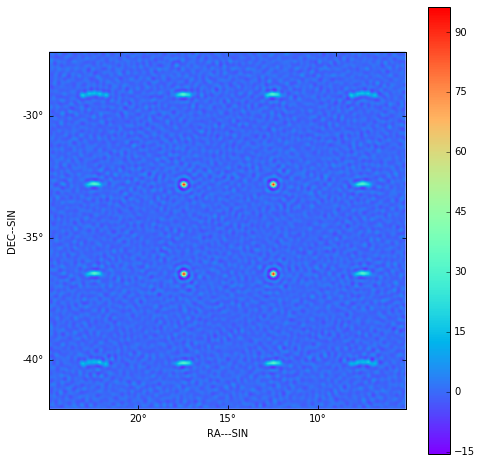

In [8]:
params = {'npixel': 256,
          'npol': 1,
          'cellsize': 0.001,
          'spectral_mode': 'channel',
          'channelwidth': 5e7,
          'reffrequency': 1e8,
          'kernel':'calculated'}

dirty = create_image_from_visibility(vt, params=params)
psf = create_image_from_visibility(vt, params=params)
vt = weight_visibility(vt, dirty)
dirty = invert_2d(vt, dirty, params=params)
psf = invert_2d(vt, dirty, dopsf=True, params=params)
psfmax = psf.data.max()
dirty.data = dirty.data / psfmax
psf.data = psf.data / psfmax

if doplot:
    show_image(dirty)

print("Max, min in dirty image = %.6f, %.6f, psfmax = %f" % (dirty.data.max(), dirty.data.min(), psfmax))
print("Max, min in PSF = %.6f, %.6f, psfmax = %f" % (psf.data.max(), psf.data.min(), psfmax))

export_image_to_fits(dirty, 'imaging-wterm_dirty.fits')
export_image_to_fits(psf, 'imaging-wterm_psf.fits')

### Use image plane partitioning (faceting) to make the image

fourier_transforms.create_wcs_from_visibility: Parsing parameters to get definition of WCS
fourier_transforms.create_wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15.0, -35.0)>, frequency 100000000.0 Hz, and bandwidth 50000000.0 Hz
create_wcs_from_visibility: uvmax = 262.634709 lambda
create_wcs_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_wcs_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
ftprocessor.predict_image_partition: predicting using 4 x 4 image partitions
image_iterators.raster: spacing of raster (64, 64)
image_iterators.raster: partition 0 (0, 0) of 16
image_iterators.raster: slice is (Ellipsis, slice(0, 64, None), slice(0, 64, None))
Pixel (32, 32) converts to direction <SkyCoord (ICRS): (ra, dec) in deg
    (22.23214895, -40.30860897)>
phaserotate_visibility: Relative cartesian representation of direction = (0.096000, -0.096000, -0.009259)
phaserotate: Phase rotation from <SkyCoord 

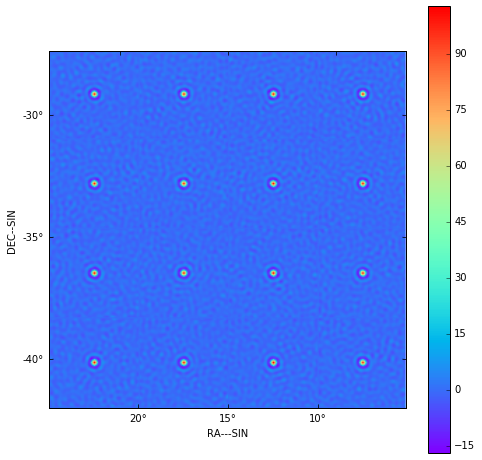

In [9]:
params = {'npixel': 256,
          'npol': 1,
          'cellsize': 0.001,
          'spectral_mode': 'channel',
          'channelwidth': 5e7,
          'reffrequency': 1e8,
          'kernel':'calculated',
          'image_partitions': 4}


dirtyFacet = create_image_from_visibility(vt, params=params)
dirtyFacet = invert_by_image_partitions(vt, dirtyFacet, image_iterator=raster_iter, params=params)
dirtyFacet.data = dirtyFacet.data / (psfmax * params['image_partitions'] * params['image_partitions'])

if doplot:
    show_image(dirtyFacet)

print("Max, min in dirty image = %.6f, %.6f, psfmax = %f" % (dirtyFacet.data.max(), dirtyFacet.data.min(), psfmax))
export_image_to_fits(dirtyFacet, 'imaging-wterm_dirtyFacet.fits')

### That was the best case. This time, we will not arrange for the points to be at the center of the partitions.

fourier_transforms.create_wcs_from_visibility: Parsing parameters to get definition of WCS
fourier_transforms.create_wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15.0, -35.0)>, frequency 100000000.0 Hz, and bandwidth 50000000.0 Hz
create_wcs_from_visibility: uvmax = 262.634709 lambda
create_wcs_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_wcs_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
ftprocessor.predict_image_partition: predicting using 2 x 2 image partitions
image_iterators.raster: spacing of raster (128, 128)
image_iterators.raster: partition 0 (0, 0) of 4
image_iterators.raster: slice is (Ellipsis, slice(0, 128, None), slice(0, 128, None))
Pixel (64, 64) converts to direction <SkyCoord (ICRS): (ra, dec) in deg
    (19.6961928, -38.58302047)>
phaserotate_visibility: Relative cartesian representation of direction = (0.064000, -0.064000, -0.004104)
phaserotate: Phase rotation from <SkyCoor

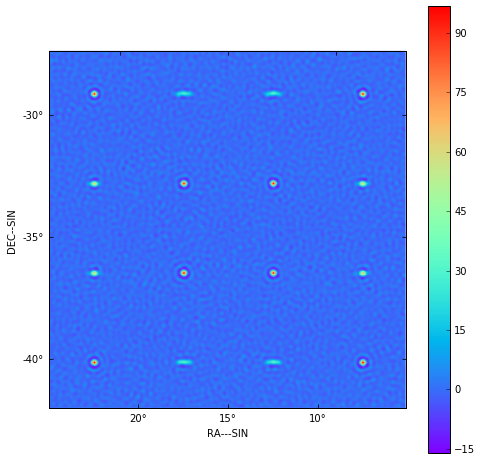

In [10]:
params = {'npixel': 256,
          'npol': 1,
          'cellsize': 0.001,
          'spectral_mode': 'channel',
          'channelwidth': 5e7,
          'reffrequency': 1e8,
          'kernel':'calculated',
          'image_partitions':2}

dirtyFacet2 = create_image_from_visibility(vt, params=params)
dirtyFacet2 = invert_by_image_partitions(vt, dirtyFacet2, image_iterator=raster_iter, params=params)
dirtyFacet2.data = dirtyFacet2.data / (psfmax * params['image_partitions'] * params['image_partitions'])

if doplot:
    show_image(dirtyFacet2)

print("Max, min in dirty image = %.6f, %.6f, psfmax = %f" % (dirtyFacet2.data.max(), dirtyFacet2.data.min(), psfmax))
export_image_to_fits(dirtyFacet2, 'imaging-wterm_dirtyFacet2.fits')

### Look at images as a function of time. Show difference from the best facet image

fourier_transforms.create_wcs_from_visibility: Parsing parameters to get definition of WCS
fourier_transforms.create_wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15.0, -35.0)>, frequency 100000000.0 Hz, and bandwidth 50000000.0 Hz
create_wcs_from_visibility: uvmax = 252.850088 lambda
create_wcs_from_visibility: Critical cellsize = 0.001977 radians, 0.113300 degrees
create_wcs_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
ftprocessor.get_2d_params: using calculated spheroidal function
fourier_transforms.create_wcs_from_visibility: Parsing parameters to get definition of WCS
fourier_transforms.create_wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15.0, -35.0)>, frequency 100000000.0 Hz, and bandwidth 50000000.0 Hz
create_wcs_from_visibility: uvmax = 252.850088 lambda
create_wcs_from_visibility: Critical cellsize = 0.001977 radians, 0.113300 degrees
create_wcs_from_visibility: Cellsize          = 0

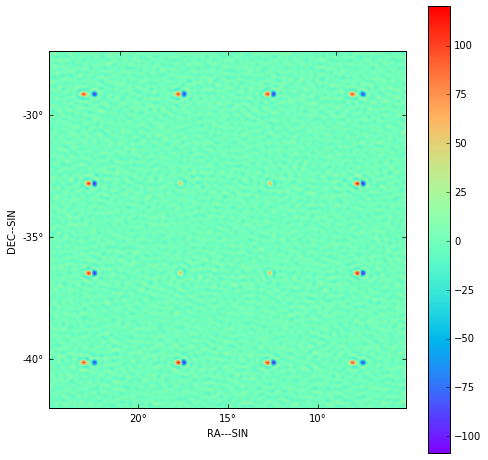

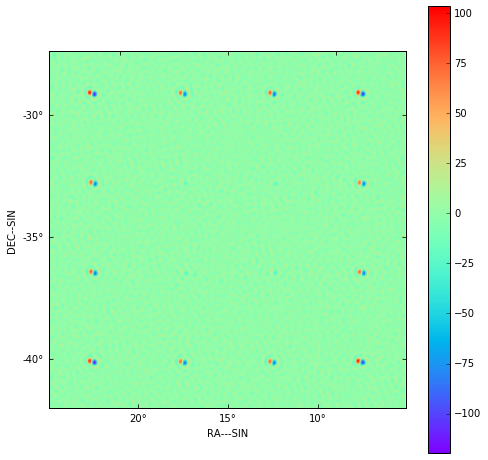

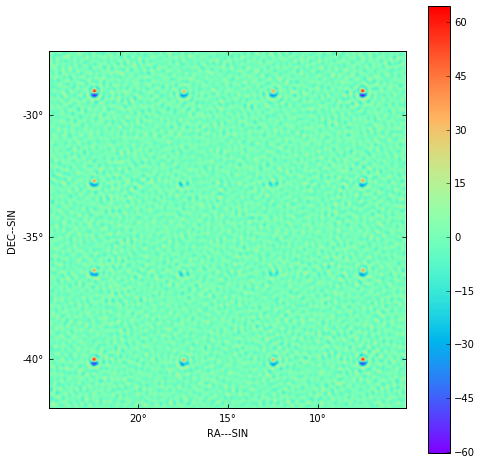

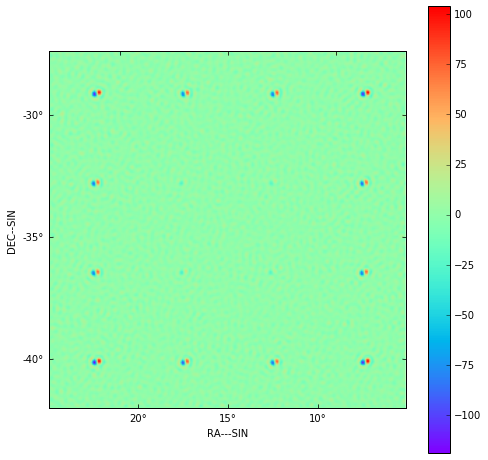

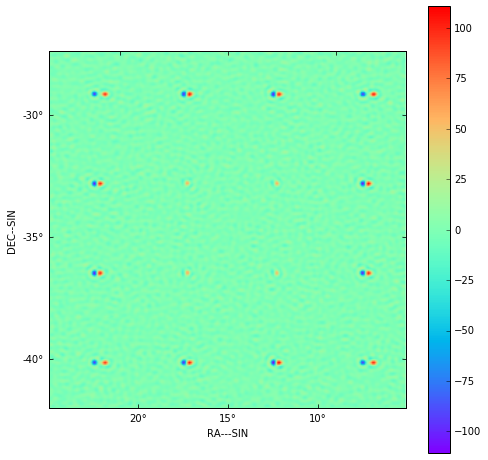

In [11]:
params = {'npixel': 256,
          'npol': 1,
          'cellsize': 0.001,
          'spectral_mode': 'channel',
          'channelwidth': 5e7,
          'reffrequency': 1e8,
          'kernel':'calculated',
          'timeslice': 3600.0}

for visslice in vis_timeslice_iter(vt, params):
    dirtySnapshot = create_image_from_visibility(visslice, params=params)
    dirtySnapshot = invert_2d(visslice, dirtySnapshot, params=params)

    psfSnapshot = create_image_from_visibility(visslice, params=params)
    psfSnapshot = invert_2d(visslice, dirtySnapshot, dopsf=True, params=params)
    psfmax = psfSnapshot.data.max()

    dirtySnapshot.data /= psfmax

    print("Max, min in dirty image = %.6f, %.6f, psfmax = %f" % 
          (dirtySnapshot.data.max(), dirtySnapshot.data.min(), psfmax))
    if doplot:
        dirtySnapshot.data -= dirtyFacet.data
        show_image(dirtySnapshot)



### Image by correcting each time slice and summing

fourier_transforms.create_wcs_from_visibility: Parsing parameters to get definition of WCS
fourier_transforms.create_wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15.0, -35.0)>, frequency 100000000.0 Hz, and bandwidth 50000000.0 Hz
create_wcs_from_visibility: uvmax = 262.634709 lambda
create_wcs_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_wcs_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
ftprocessor.get_2d_params: using calculated spheroidal function
arl.image_operations.reproject_image: Converting SIN projection from [(0, 0, 0.00738817455648685), (0, 1, 0.8149143614557424)] to []
arl.image_operations.reproject_image: Converting SIN projection from [(0, 0, -0.11281699120435856), (0, 1, 0.36610730129236274)] to []
arl.image_operations.reproject_image: Converting SIN projection from [(0, 0, -0.14588422312549926), (0, 1, -7.284911527649332e-17)] to []
arl.image_operations.reproject_image: Convert

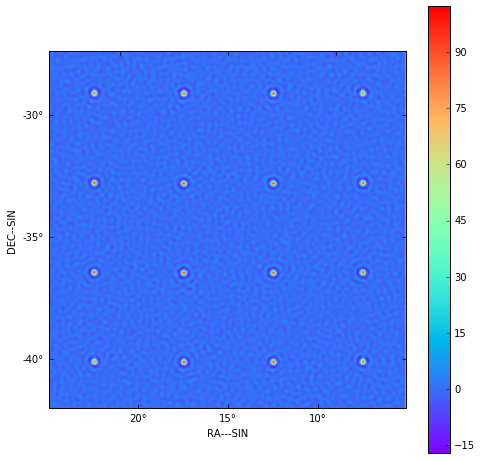

In [12]:
params = {'npixel': 256,
          'npol': 1,
          'cellsize': 0.001,
          'spectral_mode': 'channel',
          'channelwidth': 5e7,
          'reffrequency': 1e8,
          'kernel':'calculated',
          'timeslice': 300.0}

targetimage = create_image_from_visibility(vt, params=params)
targetimage = invert_timeslice(vt, targetimage, params=params)
psfimage = create_image_from_visibility(vt, params=params)
psfimage = invert_timeslice(vt, psfimage, dopsf=True, params=params)
psfmax = psfimage.data.max()

targetimage.data /= psfmax
psfimage.data /= psfmax

show_image(targetimage)
plt.show()

### Now do the same thing in parallel using pymp

fourier_transforms.create_wcs_from_visibility: Parsing parameters to get definition of WCS
fourier_transforms.create_wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15.0, -35.0)>, frequency 100000000.0 Hz, and bandwidth 50000000.0 Hz
create_wcs_from_visibility: uvmax = 262.634709 lambda
create_wcs_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_wcs_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
ftprocessor.get_2d_params: using calculated spheroidal function
fourier_transforms: invert_timeslice.Processing 5 time slices 4-way parallel
Entering `Parallel` context (level 0). Forking...
Forked to processes: [89651, 89652, 89653].
arl.image_operations.reproject_image: Converting SIN projection from [(0, 0, -0.11281699120435838), (0, 1, -0.36610730129236285)] to []
arl.image_operations.reproject_image: Converting SIN projection from [(0, 0, 0.007388174556486884), (0, 1, -0.8149143614557426)] to []
arl.image

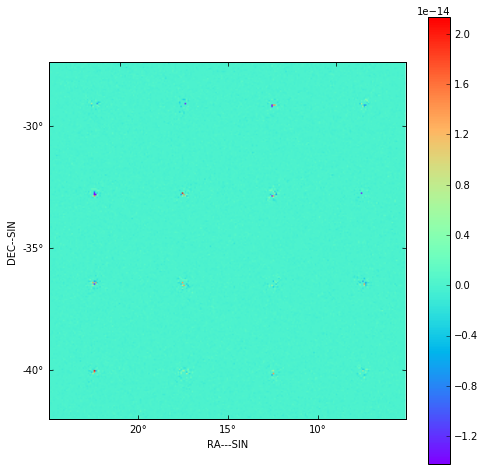

In [13]:
params = {'npixel': 256,
          'npol': 1,
          'cellsize': 0.001,
          'spectral_mode': 'channel',
          'channelwidth': 5e7,
          'reffrequency': 1e8,
          'kernel':'calculated',
          'timeslice': 300.0,
          'nprocessor':4}

targetimagepar = create_image_from_visibility(vt, params=params)
targetimagepar = invert_timeslice(vt, targetimage, params=params)
targetimagepar.data /= psfmax

targetimagepar.data -= targetimage.data
show_image(targetimagepar)
plt.show()

### Now try w projection. WProjection is implemented via invert_2d with a specialised kernel.

fourier_transforms.create_wcs_from_visibility: Parsing parameters to get definition of WCS
fourier_transforms.create_wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15.0, -35.0)>, frequency 100000000.0 Hz, and bandwidth 50000000.0 Hz
create_wcs_from_visibility: uvmax = 262.634709 lambda
create_wcs_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_wcs_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
ftprocessor.get_2d_params: Fresnel number = 16.384000
ftprocessor.get_2d_params: Recommended wstep = 1.535926
ftprocessor.get_2d_params: using w projection with wstep = 1.535926
ftprocessor.get_2d_params: w support = 64
variable_kernels.w_kernel_lambda: Maximum w = 166.951695 wavelengths
fourier_transforms.create_wcs_from_visibility: Parsing parameters to get definition of WCS
fourier_transforms.create_wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15.0, -35.0)>, frequency 10000

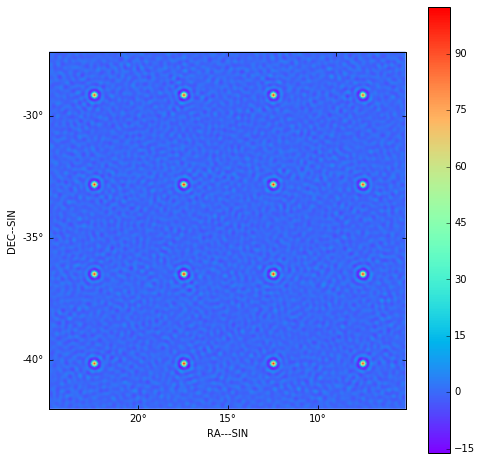

In [14]:
params = {'npixel': 256,
          'npol': 1,
          'cellsize': 0.001,
          'spectral_mode': 'channel',
          'channelwidth': 5e7,
          'reffrequency': 1e8,
          'kernel':'wprojection',
          'wloss':0.05}

dirtyWProjection = create_image_from_visibility(vt, params=params)
dirtyWProjection = invert_2d(vt, dirtyWProjection, params=params)
psfWProjection = create_image_from_visibility(vt, params=params)
psfWProjection = invert_2d(vt, psfWProjection, dopsf=True, params=params)
psfmax = psfWProjection.data.max()
dirtyWProjection.data = dirtyWProjection.data / psfmax
psfWProjection.data = psfWProjection.data / psfmax

if doplot:
    show_image(dirtyWProjection)

print("Max, min in dirty image = %.6f, %.6f, psfmax = %f" % (dirtyWProjection.data.max(), 
                                                             dirtyWProjection.data.min(), psfmax))
export_image_to_fits(dirtyWProjection, 'imaging-wterm_dirty_WProjection.fits')
export_image_to_fits(psfWProjection, 'imaging-wterm_psf_WProjection.fits')